## Algorithmic Trading: Mean Reversion 

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import back_testing as bt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression


### Import Libraries

### Get Data

In [184]:
# Load data from CSV
csv_file_path = 'USA30IDXUSD.csv'
csv_file_path4h = 'USA30IDXUSD4h.csv'
df_ltf = pd.read_csv(csv_file_path)
df_htf = pd.read_csv(csv_file_path4h)

Format HTF Data

In [185]:
# Combine Date and Timestamp columns into a single datetime column
df_htf['date'] = pd.to_datetime(df_htf['Date'].astype(str) + ' ' + df_htf['Timestamp'].astype(str))

# Drop the original Date and Timestamp columns if no longer needed
df_htf.drop(['Date', 'Timestamp'], axis=1, inplace=True)

# Rename columns
df_htf = df_htf.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Reverse index
df_htf = df_htf.reindex(index=df_htf.index[::-1])
df_htf.reset_index(level=0, inplace=True)

# Drop the 'index' column if it's not needed
df_htf.drop('index', axis=1, inplace=True)


format LTF Data

In [186]:
# Combine Date and Timestamp columns into a single datetime column
df_ltf['date'] = pd.to_datetime(df_ltf['Date'].astype(str) + ' ' + df_ltf['Timestamp'].astype(str))

# Drop the original Date and Timestamp columns if no longer needed
df_ltf.drop(['Date', 'Timestamp'], axis=1, inplace=True)

# Rename columns
df_ltf = df_ltf.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})

# Reverse index
df_ltf = df_ltf.reindex(index=df_ltf.index[::-1])
df_ltf.reset_index(level=0, inplace=True)

# Drop the 'index' column if it's not needed
df_ltf.drop('index', axis=1, inplace=True)

Select Start and End Time

In [187]:
df_ltf = df_ltf[((df_ltf['date'] >= pd.to_datetime('2023-01-01')) & (df_ltf['date'] <= pd.to_datetime('2024-08-05')))]
df_htf = df_htf[((df_htf['date'] >= pd.to_datetime('2023-01-01')) & (df_htf['date'] <= pd.to_datetime('2024-08-07')))]

### Calculate ma

In [188]:
#Short moving averages (5-20 periods) are best suited for short-term trends and trading
df_ltf['ma_200'] = df_ltf['close'].rolling(200).mean()
df_htf['ema_100'] = df_htf['close'].ewm(span=100, adjust=False).mean()

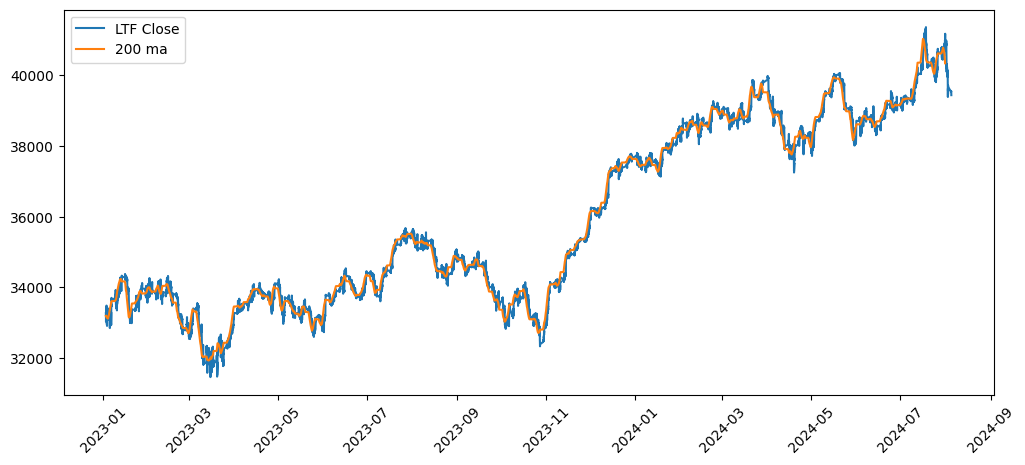

In [189]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df_ltf['date'], df_ltf['close'], label = 'LTF Close')
plt.plot(df_ltf['date'], df_ltf['ma_200'], label = '200 ma')

plt.legend()
plt.show()


Calculate the Angle of the Linear regression 

In [190]:
def calculate_ma_angle(df, ma_column='ema_100', window=10):
    """
    Calculate the angle of the moving average line over a rolling window.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the moving average column.
    - ma_column (str): Name of the column containing the moving average values.
    - window (int): Number of data points to include in each rolling window.

    Returns:
    - List of angles in degrees with NaNs for the initial rows without enough data.
    """
    angles = np.full(len(df), np.nan)  # Initialize with NaNs

    for i in range(len(df) - window + 1):
        # Select 'window' data points
        subset = df.iloc[i:i + window]
        
        # Prepare data for calculating the slope of the moving average
        X = np.arange(window).reshape(-1, 1)  # Time steps (0, 1, 2, ..., window-1)
        y = subset[ma_column].values  # Moving average values

        # Fit linear regression model on the entire window
        model_window = LinearRegression().fit(X, y)
        slope_window = model_window.coef_[0]  # Slope of the regression line for the entire window

        # Calculate angle in degrees
        angle_rad = np.arctan(slope_window)
        angle_deg = np.degrees(angle_rad)
        angles[i + window - 1] = angle_deg  # Assign angle to the last point of the window

    return angles


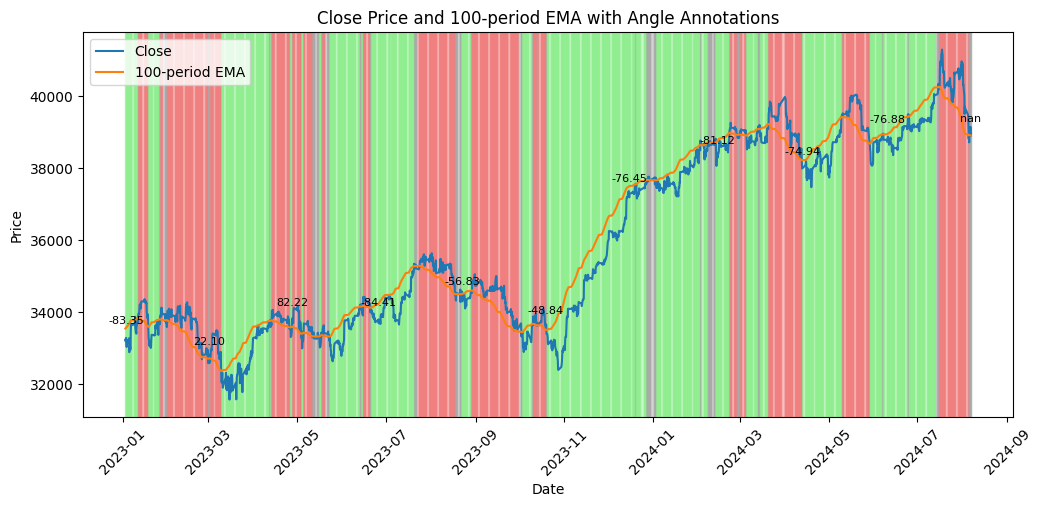

In [191]:

df_htf['ma_angle'] = calculate_ma_angle(df_htf, ma_column='ema_100')

# Plot for validation
plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)

# Plotting the close price and 100-period moving average
plt.plot(df_htf['date'], df_htf['close'], label='Close')
plt.plot(df_htf['date'], df_htf['ema_100'], label='100-period EMA')

# Fill background based on angle
for i in range(len(df_htf) - 1):
    angle = df_htf['ma_angle'].iloc[i]
    if angle > 50:
        plt.axvspan(df_htf['date'].iloc[i], df_htf['date'].iloc[i + 1], color='lightcoral', alpha=0.5)  # Bullish: Light Green
    elif angle < -50:
        plt.axvspan(df_htf['date'].iloc[i], df_htf['date'].iloc[i + 1], color='lightgreen', alpha=0.5)  # Bearish: Light Coral
    else:
        plt.axvspan(df_htf['date'].iloc[i], df_htf['date'].iloc[i + 1], color='darkgrey', alpha=0.5)  # Ranging: Dark Grey

# Annotate the angle values
for i in range(0, len(df_htf), max(1, len(df_htf) // 10)):  # Adjust the interval as needed
    plt.annotate(f'{df_htf["ma_angle"].iloc[i]:.2f}', 
                 (df_htf['date'].iloc[i], df_htf['close'].iloc[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=8, 
                 color='black')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price and 100-period EMA with Angle Annotations')
plt.legend()
plt.show()

### Calculate RSI

In [192]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [193]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [194]:

period = 13

#Calculate price delta
df_ltf['delta'] = df_ltf['close'].diff()

#Classify delta into gain & loss
df_ltf['gain'] = df_ltf['delta'].apply(lambda x:gain(x))
df_ltf['loss'] = df_ltf['delta'].apply(lambda x:loss(x))

#Calculate ema 
df_ltf['ema_gain'] = df_ltf['gain'].ewm(period).mean()
df_ltf['ema_loss'] = df_ltf['loss'].ewm(period).mean()

#Calculate RSI
df_ltf['rs'] = df_ltf['ema_gain']/df_ltf['ema_loss']
df_ltf['rsi'] = df_ltf['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

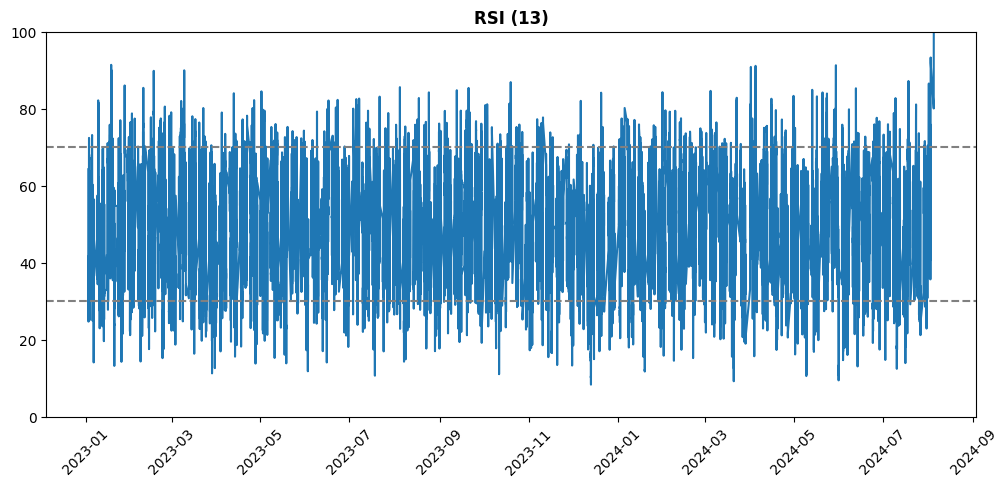

In [195]:
# Ensure 'date' is a column and not the index
if 'date' in df_ltf.index.names:
    df_ltf.reset_index(inplace=True)

# Plot RSI for validation
plt.figure(figsize=(12, 5))
plt.xticks(rotation=45)

x_axis = df_ltf['date']

x_axis = df_ltf['date']

plt.plot(x_axis, df_ltf['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (13)', fontweight="bold")
plt.ylim([0, 100])

### Implementing buy/sell

#### Rules:
    1. Buy when 13-period RSI below 30 (buy next day) & Price below lower bollinger band
    2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band

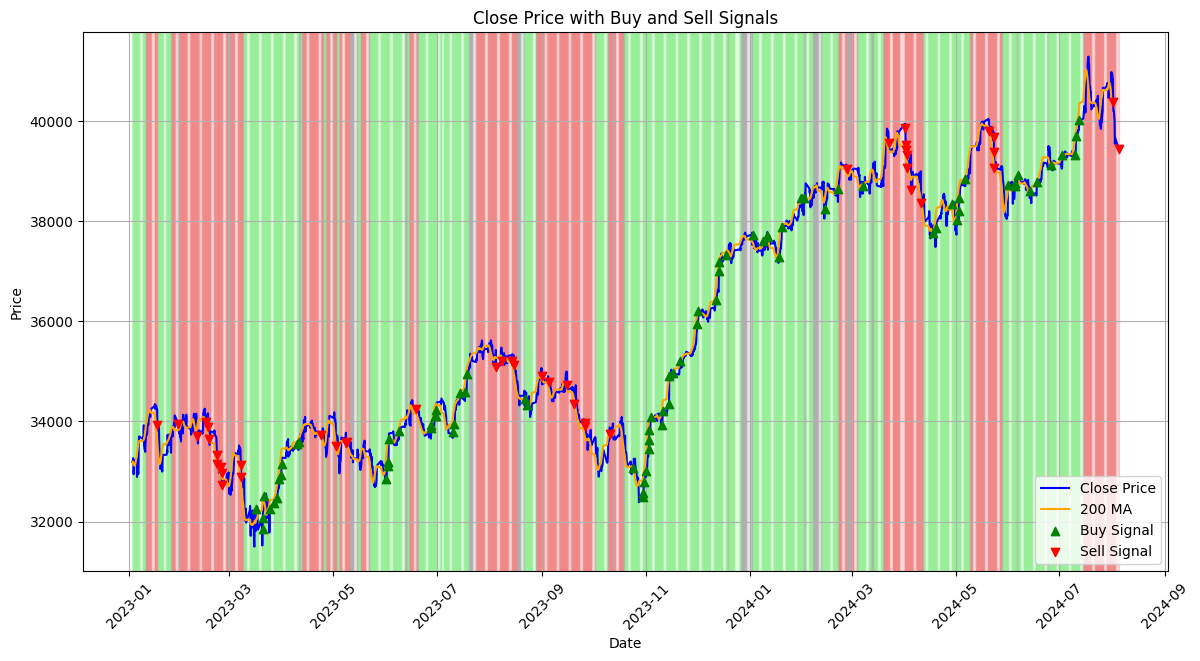

In [204]:


# Initialize signal column
df_ltf['signal'] = 0

# Merge LTF and HTF DataFrames on datetime
df_combined = pd.merge(df_ltf, df_htf[['date', 'ma_angle']], on='date', how='inner')

# Define conditions for buy and sell signals
buy_condition = (df_combined['rsi'] < 30) & (df_combined['ma_angle'] < -50)
sell_condition = (df_combined['rsi'] > 70) & (df_combined['ma_angle'] > 50)

# Identify buy and sell signals
df_combined.loc[buy_condition, 'signal'] = 1
df_combined.loc[sell_condition, 'signal'] = -1

# Shift signals to the next trading day
df_combined['signal'] = df_combined['signal'].shift()
df_combined['signal'] = df_combined['signal'].fillna(0)

# Plot for validation
plt.figure(figsize=(14, 7))

# Plot the close price and moving average
plt.plot(df_combined['date'], df_combined['close'], label='Close Price', color='blue')
plt.plot(df_combined['date'], df_combined['ma_200'], label='200 MA', color='orange')

# Plot buy and sell signals
plt.scatter(df_combined['date'][df_combined['signal'] == 1], df_combined['close'][df_combined['signal'] == 1], marker='^', color='g', label='Buy Signal', zorder=5)
plt.scatter(df_combined['date'][df_combined['signal'] == -1], df_combined['close'][df_combined['signal'] == -1], marker='v', color='r', label='Sell Signal', zorder=5)

# Fill background based on angle
for i in range(len(df_combined) - 1):
    angle = df_combined['ma_angle'].iloc[i]
    if angle < -50:
        plt.axvspan(df_combined['date'].iloc[i], df_combined['date'].iloc[i + 1], color='lightgreen', alpha=0.3)  # Bearish: Light Coral
    elif angle > 50:
        plt.axvspan(df_combined['date'].iloc[i], df_combined['date'].iloc[i + 1], color='lightcoral', alpha=0.3)  # Bullish: Light Green
    else:
        plt.axvspan(df_combined['date'].iloc[i], df_combined['date'].iloc[i + 1], color='darkgrey', alpha=0.3)  # Neutral: Dark Grey

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price with Buy and Sell Signals')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

### Backtesting Strategy

In [18]:
bt.backtest_dataframe(df_ltf)

Buying at 40660.215 on 2024-07-31 05:00:00
Selling at 40583.251 on 2024-07-29 19:15:00
Buying at 40600.739 on 2024-07-26 19:45:00
Selling at 40329.739 on 2024-07-25 16:45:00
Buying at 40295.205 on 2024-07-19 19:45:00
Selling at 40598.797 on 2024-07-19 12:30:00
Buying at 40817.651 on 2024-07-17 13:00:00
Selling at 40190.799 on 2024-07-12 19:00:00
Buying at 39850.239 on 2024-07-12 13:45:00
Selling at 39414.203 on 2024-07-09 17:30:00
Buying at 39189.039 on 2024-07-09 13:45:00
Selling at 39544.775 on 2024-07-08 14:45:00
Buying at 39175.239 on 2024-07-02 17:30:00
Selling at 39366.215 on 2024-07-01 13:30:00
Buying at 39030.751 on 2024-06-28 19:15:00
Selling at 39396.799 on 2024-06-28 14:30:00
Buying at 39129.263 on 2024-06-28 00:45:00
Selling at 39128.863 on 2024-06-26 19:45:00
Buying at 39065.251 on 2024-06-25 16:15:00
Selling at 39281.239 on 2024-06-25 14:15:00
Buying at 39256.599 on 2024-06-24 13:15:00
Selling at 38847.751 on 2024-06-18 22:45:00
Buying at 38795.787 on 2024-06-18 18:45:00


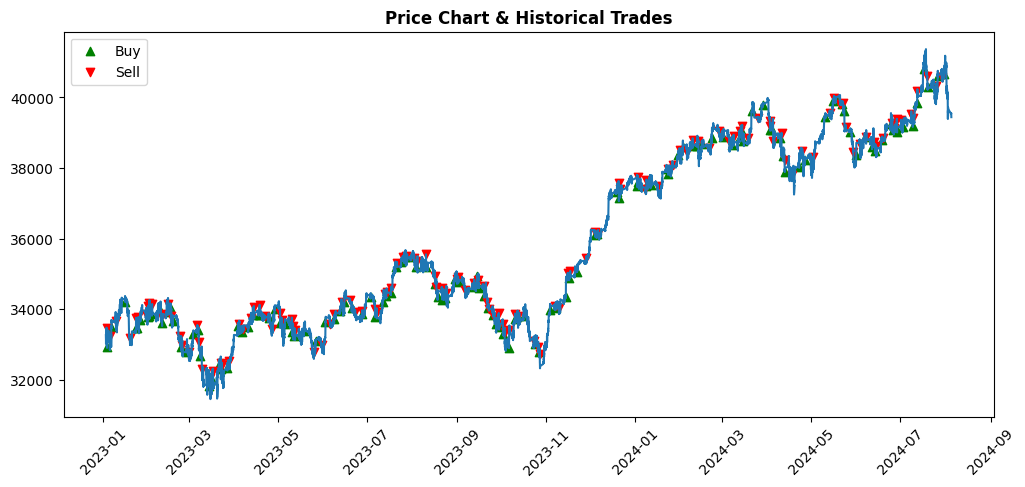

In [77]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df_ltf['close'])
plt.scatter(df_ltf[(df_ltf['signal'] == 1)]['buy_date'], df_ltf[(df_ltf['signal'] == 1)]['close'], label = 'Buy', marker='^', c='g')
plt.scatter(df_ltf[(df_ltf['signal'] == -1)]['sell_date'], df_ltf[(df_ltf['signal'] == -1)]['close'], label = 'Sell', marker='v', c='r')

plt.title('Price Chart & Historical Trades', fontweight="bold")
plt.legend()
plt.show()